In [1]:
import sqlite3
import pandas as pd
import math
# Create your connection.
import numpy as np
import tulipy as ti
import seaborn as sns
import keras
import copy
print(keras.__version__)
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
from tradingWithPython import sharpe


Using TensorFlow backend.
/Users/adrian/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/adrian/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/adrian/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/adrian/anaconda3/lib/python3.7/site-packages/t

2.2.4


/Users/adrian/anaconda3/lib/python3.7/site-packages/tradingWithPython/lib/yahooFinance.py:262: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(open(dataFile,'r'))


In [2]:
from tradingWithPython import sharpe


In [3]:
db = sqlite3.connect('/Users/adrian/gekko/history/binance_0.1.db')

cursor = db.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
for table_name in tables:
    table_name = table_name[0]
    table = pd.read_sql_query("SELECT * from %s" % table_name, db)
    table.to_csv(table_name + '.csv', index_label='index')
dm = pd.read_csv("candles_USDT_BTC.csv")
dm = dm.drop(columns=['vwp', 'trades', 'id', 'index'])

In [91]:
datam = dm.tail(1440*50)

In [5]:
datam.shape[0]

288000

In [92]:
strd = pd.DataFrame(index = datam.index)

strd['cc'] = 100* datam['close'].pct_change()
strd['co'] = 100* (datam['open']/datam['close'].shift(1) -1)
strd['oc'] = 100* (datam['close']/datam['open'] -1)
#strd.plot()
print(sharpe(strd['cc']))

0.15144159705762772


In [93]:
final = np.zeros(shape = datam.shape[0])

In [94]:
close = np.array(datam.close)
open = np.array(datam.open)
high = np.array(datam.high)
low = np.array(datam.low)
volume = np.array(datam.volume)


In [9]:
def bbstr(std,per):
    bl, bm, bu = ti.bbands(close, per, std)

In [130]:
std = 2
per = 30
bl, bm, bu = ti.bbands(close, per, std)

bl = np.pad(bl, (per-1, 0), 'constant')
bm = np.pad(bm, (per-1, 0), 'constant')
bu = np.pad(bu, (per-1, 0), 'constant')

up = np.pad(ti.crossover(close, bl), (1,0), 'constant')
sdown = np.pad(ti.crossover(bl, close), (1,0), 'constant')
down = np.pad(ti.crossover(bu, close), (1,0), 'constant')
sup = np.pad(ti.crossover(close, bu), (1,0), 'constant')
mup = np.pad(ti.crossover(close, bm), (1,0), 'constant')
mdown = np.pad(ti.crossover(bm, close), (1,0), 'constant')

str = -up + down #- sup + sdown #- mup + mdown

str = -up + down + sup
prev = 0
for i in range(0, str.size):
    if prev<1:
        if str[i]>0:
            str[i]=1
        else: str[i]=0
    if prev==1:
        if str[i]<0:
            str[i]=0
        else: str[i]=1
    prev = str[i]
    
    
long = pd.DataFrame(data = str)
long = long.shift(1)
npl = np.array(long[0].fillna(0))
dnpl = np.absolute(np.pad(np.diff(npl), (1,0), 'constant'))

0.04853728297150225


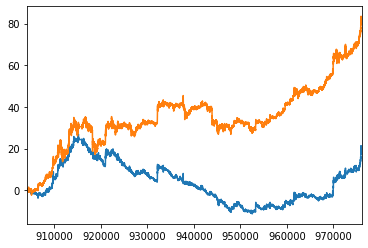

In [131]:
arr = (np.array(strd.cc.fillna(0)) - 0.075 * dnpl) * npl
strd['pnlh'] = pd.DataFrame(data = arr, index = strd.index)
print(sharpe(strd['pnlh']))
strd['pnlh'].cumsum().plot()
strd['cc'].cumsum().plot()

In [67]:
strd['npl'] = pd.DataFrame(data = npl, index = strd.index)
strd['dnpl'] = pd.DataFrame(data = dnpl, index = strd.index)
strd[['npl', 'dnpl']]

,npl,dnpl
832090,0.0,0.0
832091,0.0,0.0
832092,0.0,0.0
832093,0.0,0.0
832094,0.0,0.0
832095,0.0,0.0
832096,0.0,0.0
832097,0.0,0.0
832098,0.0,0.0
832099,0.0,0.0


In [243]:
final = final + npl

In [203]:
111111

(144000,)

In [244]:
final = final / 6

0.06384344423198535


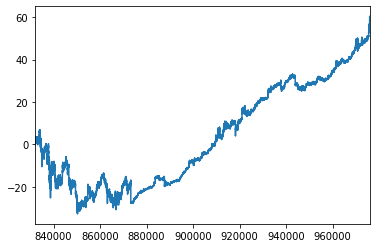

In [245]:
arr = np.array(strd.cc.fillna(0)) * final
strd['pnlh'] = pd.DataFrame(data = arr, index = strd.index)
print(sharpe(strd['pnlh']))
strd['pnlh'].cumsum().plot()

In [ ]:
strd['pnlhp'] = (strd['pnlh'].fillna(0) + 100)/100

strd['pnlhp'] = strd['pnlhp']-0.00075*long.fillna(0).diff().abs().fillna(0) 
strd.pnlhp.astype(object).product()
strd['pnlhc'] = strd['pnlh'].fillna(0)
strd['pnlcumsum']=strd['pnlh'].fillna(0).cumsum()
strd['pnlhc'] = strd['pnlhc']-0.00075*long.fillna(0).diff().abs().fillna(0)
strd['pnlhc'].cumsum().plot()

0.04785510640045365


0.36767906954731533


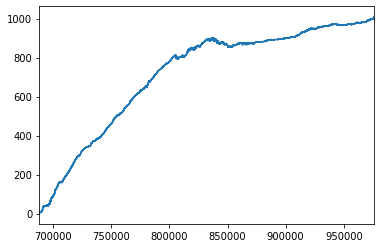

array([nan,  0.,  0., ...,  1.,  1.,  1.])